# Adaptive Questionnaires for Voting Advice Applications

In [1]:
import WassersteinTSNE as WT

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import sys
sys.path.insert(0, '../../src')
import utils.visualization as vis
import utils.preprocession as prep
from models.IDEAL import IDEAL



## Config

In [9]:
save_figures = True
folder_name = 'Smartvote'
data_name = 'Binary'
p = 90

## Data

In [10]:
def savefig(fig, name='TestFigure'): 
    if save_figures:
        fig.savefig(f"../../reports/ic2s2-abstract/figures/{folder_name}_{data_name}_{name}.pdf") 
        fig.savefig(f"../../reports/ecml-paper/figures/{folder_name}_{data_name}_{name}.pdf") 

folder_path = f"../../data/{folder_name}"
data_path = f"../../data/{folder_name}/{data_name}"

test_users = pd.read_csv(f'{folder_path}/test_candidates.csv', index_col=0)
train_users = pd.read_csv(f'{folder_path}/train_candidates.csv', index_col=0)

train_reactions = pd.read_csv(f'{data_path}/train_reactions_0.csv', index_col=0)
start_reactions = pd.read_csv(f'{data_path}/test_reactions_{p}.csv', index_col=0)
test_reactions = pd.read_csv(f'{data_path}/test_reactions_0.csv', index_col=0)

statements = pd.read_csv(f"../../data/{folder_name}/statements.csv", index_col=0)

## Model

In [4]:
method_path = f"../../embeddings/IDEAL/{folder_name}"
start_embedding = pd.read_csv(f'{method_path}/test_embedding_0_{p}.csv', index_col=0)
test_embedding = pd.read_csv(f'{method_path}/test_embedding_0_0.csv', index_col=0)
train_embedding = pd.read_csv(f'{method_path}/train_embedding_0.csv', index_col=0)

ideal = IDEAL(pd.read_csv(f'{method_path}/betabar_0.csv', index_col=0), 
              pd.read_csv(f'{method_path}/xbar_0.csv', index_col=0),
              index=train_reactions.index, columns=train_reactions.columns)

d, r = 2, 200
ideal.make_probabilistic(d=d, r=r)

## Questions

(15, 5)

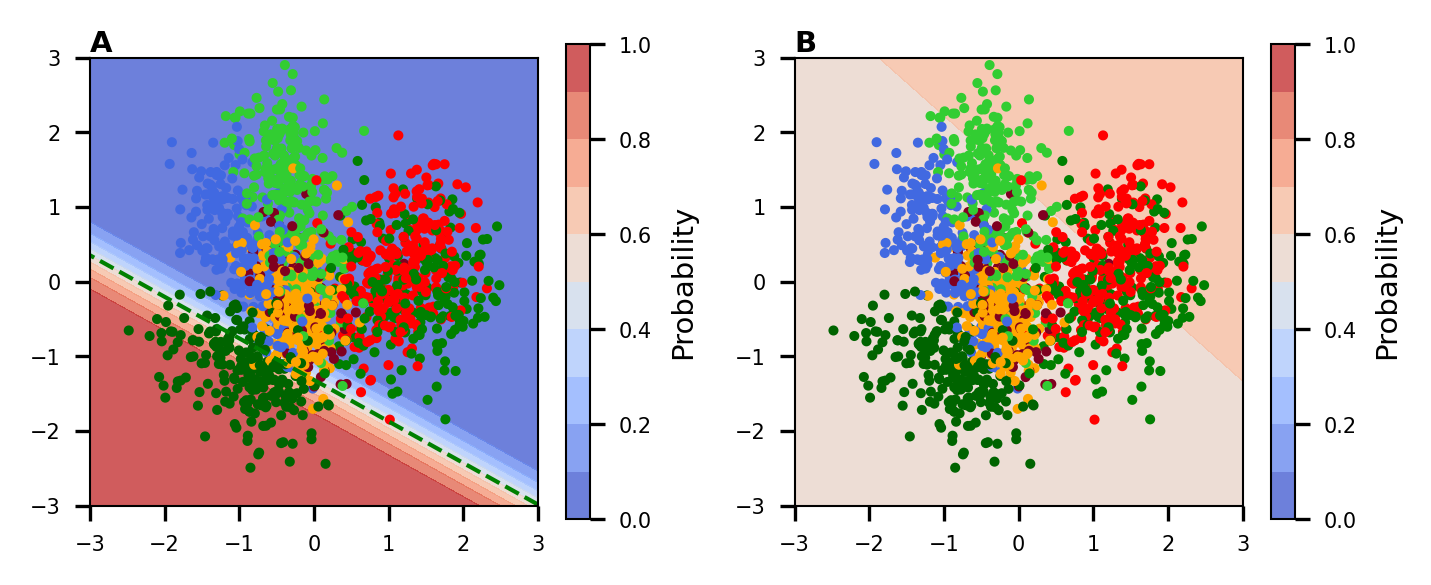

In [67]:
def plotQuestion(q, ax=None, mark=None):
    #_, ax, _ = vis.figure(ax)

    ax = vis.plotEmbedding(train_embedding, ax=ax, s=2, c=train_users['color'])            
    vis.plotFeature(ideal.predict, q, ax=ax)
    if mark is not None:
        ax.scatter(mark[0], mark[1], marker='x', color='black', s=5, lw=1, label='Optimized Coordinates', zorder=5)
def compareQuestions(q1, q2, mark=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(vis.textwidth,0.4*vis.textwidth))    
    for ax in (ax1,ax2):
        ax.set(xlim=(-3,3),
                ylim=(-3,3))
    plotQuestion(q2, ax=ax1, mark=mark)
    plotQuestion(q1, ax=ax2, mark=mark)

    fig.text(-0,1, 'A', va='bottom', ha='left', weight='bold', transform=ax1.transAxes)
    fig.text(-0,1, 'B', va='bottom', ha='left', weight='bold', transform=ax2.transAxes)

    # labels = train_users['party'].unique() 
    # handles = [mpl.lines.Line2D([], [], color=prep.partycolors[name], marker='o', linestyle='None', label=name) for name in labels]
    # fig.legend(handles=handles, labels=list(labels), 
    #             ncols=1, facecolor='white', loc='center right',bbox_to_anchor=(0.09, 0.5))


    fig.tight_layout()
    savefig(fig, f'CompareQuestions_{q1}_{q2}')
    return fig


variances = ideal.items.apply(lambda row: np.linalg.norm(row[['Discrimination D1', 'Discrimination D2']]), axis=1)
q1, q2 = variances.argmin(), variances.argmax()
fig = compareQuestions(q1, q2)
q1, q2

## Posterior

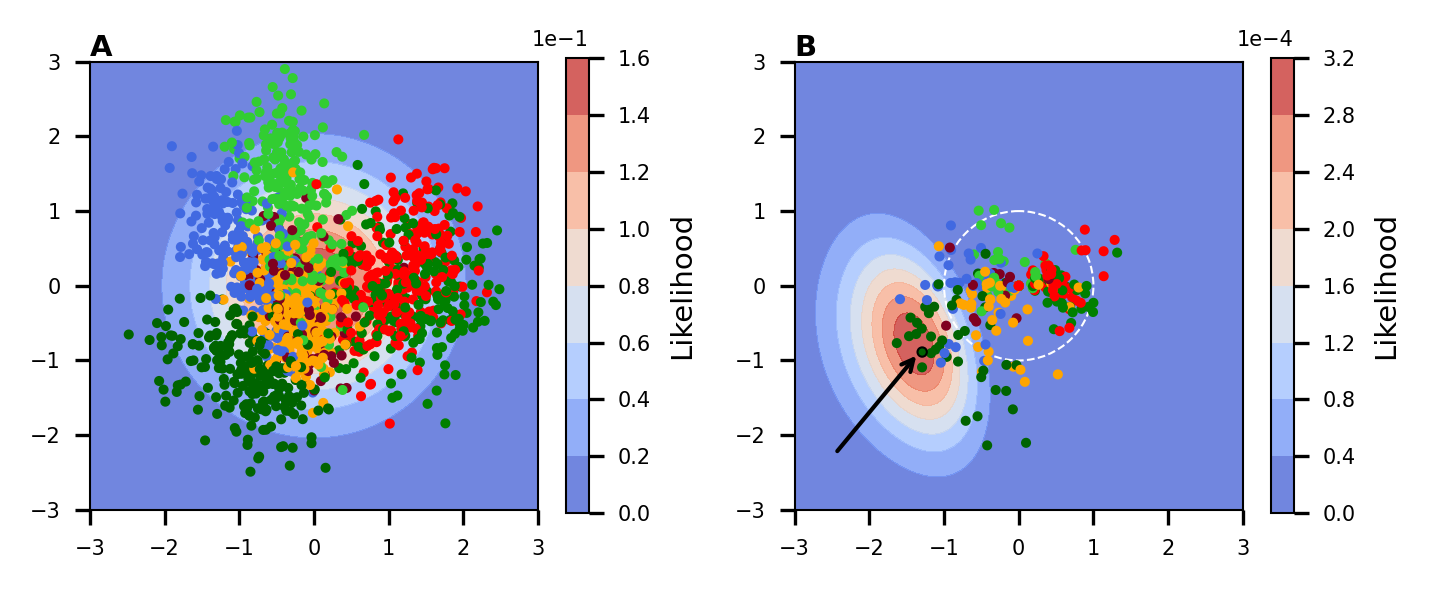

In [11]:
def showUser(n,q, method=ideal.objective):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(vis.textwidth,0.4*vis.textwidth))
    for ax in (ax1,ax2):
        ax.set(xlim=(-3,3),
                ylim=(-3,3))
    ax2 = vis.plotEmbedding(start_embedding, n=n, ax=ax2, s=2, c=test_users['color'],
                            highlight={'s':5, 'lw':.5})            
    # ax1.set_title(f'Posterior after 5 questions\n for Test User {n}')
    #vis.extendLegend(ax, train_users['party'].unique(), lambda name: prep.partycolors[name], ncols=2)

    user = start_reactions.loc[n]
    answers = user.loc[~user.isna()]
    vis.plotObjective(method, answers, d=0, r=r, ax=ax2, clabel='Likelihood')
    vis.plotObjective(lambda X, answers: ideal.prior.pdf(X), answers, ax=ax1, clabel='Likelihood')
    ax1 = vis.plotEmbedding(train_embedding, ax=ax1, s=2, c=train_users['color'])  
    # ax2.set_title(f'Train Users over Gaussian Prior')
    fig.text(-0,1, 'A', va='bottom', ha='left', weight='bold', transform=ax1.transAxes)
    fig.text(-0,1, 'B', va='bottom', ha='left', weight='bold', transform=ax2.transAxes)

    fig.tight_layout()
    return fig, ax2

fig, ax = showUser(459, 0, ideal.posterior)
G = WT.GaussianDistribution(np.array([0,0]), WT.arr2cov(np.eye(2)))
# G = WT.GaussianDistribution().estimate(ideal.train_embedding.values)
ax = vis.plotGaussian(G, ax=ax, edgecolor='white', linewidth=0.5, zorder=1)
ax.annotate("", xy=(-1.3,-0.85), xytext=(-2.5, -2.3),
            arrowprops=dict(arrowstyle="->"))
savefig(fig, 'PosteriorVisualization')

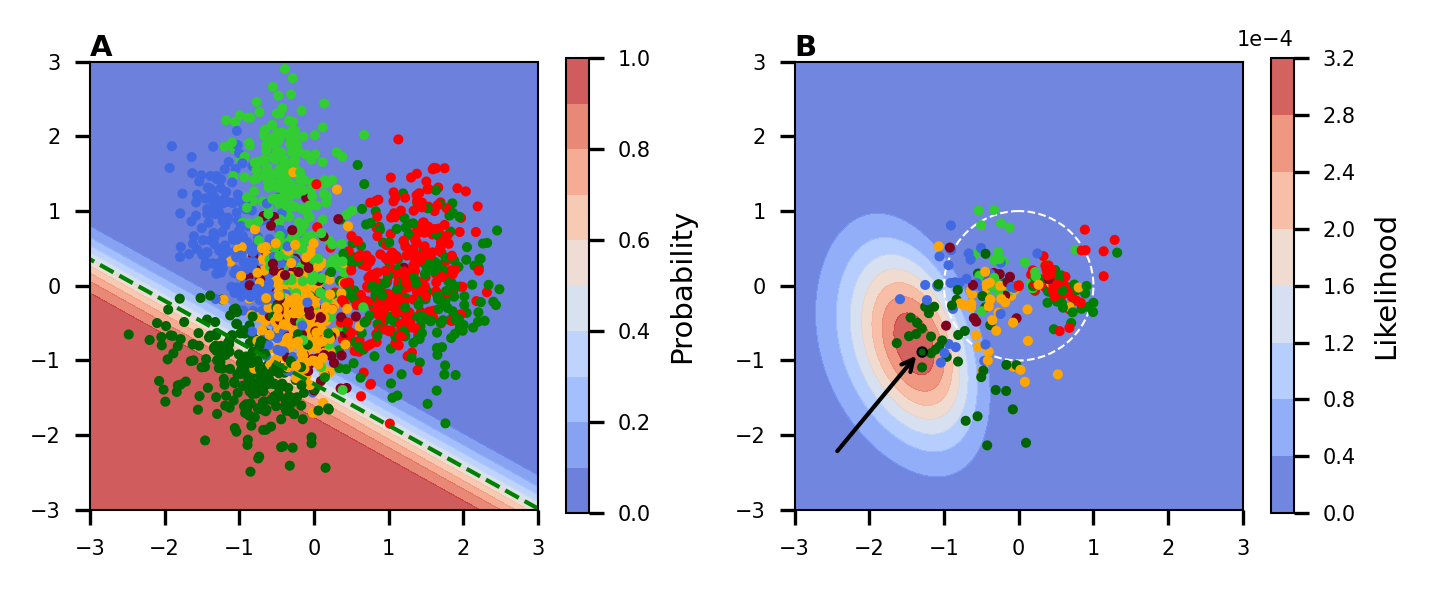

In [5]:
variances = ideal.items.apply(lambda row: np.linalg.norm(row[['Discrimination D1', 'Discrimination D2']]), axis=1)
q1, q2 = variances.argmin(), variances.argmax()
n = 459
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(vis.textwidth,0.4*vis.textwidth))    
for ax in (ax1,ax2):
    ax.set(xlim=(-3,3),
            ylim=(-3,3))
    
ax1 = vis.plotEmbedding(train_embedding, ax=ax1, s=2, c=train_users['color'])            
vis.plotFeature(ideal.predict, q2, ax=ax1)

ax2 = vis.plotEmbedding(start_embedding, n=n, ax=ax2, s=2, c=test_users['color'],
                        highlight={'s':5, 'lw':.5})            
# ax1.set_title(f'Posterior after 5 questions\n for Test User {n}')
#vis.extendLegend(ax, train_users['party'].unique(), lambda name: prep.partycolors[name], ncols=2)

user = start_reactions.loc[n]
answers = user.loc[~user.isna()]
vis.plotObjective(ideal.posterior, answers, d=0, r=r, ax=ax2, clabel='Likelihood')

fig.text(-0,1, 'A', va='bottom', ha='left', weight='bold', transform=ax1.transAxes)
fig.text(-0,1, 'B', va='bottom', ha='left', weight='bold', transform=ax2.transAxes)

G = WT.GaussianDistribution(np.array([0,0]), WT.arr2cov(np.eye(2)))
# G = WT.GaussianDistribution().estimate(ideal.train_embedding.values)
ax2 = vis.plotGaussian(G, ax=ax2, edgecolor='white', linewidth=0.5, zorder=1)
ax2.annotate("", xy=(-1.3,-0.85), xytext=(-2.5, -2.3),
            arrowprops=dict(arrowstyle="->"))
fig.tight_layout()

savefig(fig, f'IDEAL_Q{q2}_N{n}')

## Results

In [5]:
folder_name = 'Smartvote'
data_name = 'Binary'
suffix = 'candidates'

metrics = ['Accuracy', 'RMSE']
models  = ['IDEAL']

results = lambda methods: {selector: pd.read_csv(f'../../results/ALVAA/{folder_name}_{data_name}_IDEAL_{selector}_{suffix}.csv', index_col=0) for selector in methods}

In [6]:
def showResults(results, **kwargs):
    params = {'title': None, 
              'metric': 'Accuracy', 
              'xmin': 0, 'xmax':None, 
              'ylim':(0.5,1), 
              'ncol':3, 
              'linekwargs': {},
              'savefig':False, 'suffix': 'results',
              'singleUser': False,
              'includeGiven': False,
              'figax': None,
              'legend': True,
              'ratio':0.4}
    
    params.update(kwargs)
    n_queries = [test_reactions.size, test_reactions.shape[1]][params['singleUser']]
    if params['title'] is None:
        params['title'] = f"{params['metric']} when predicting {['the remaining', 'all'][params['includeGiven']]} values {['for all users', 'per user'][params['singleUser']]}"
    xmin, xmax = params['xmin'], params['xmax'] if params['xmax'] is not None else n_queries-1
    best_value = {'Accuracy': 1, 'RMSE':0, 'Candidates':1}
    function = lambda data: (best_value[params['metric']]-data) * data.index/n_queries + data
    if params['figax'] is None:
        fig, ax = plt.subplots(figsize=(vis.textwidth,params['ratio']*vis.textwidth))
    else:
        fig, ax = params['figax']
    for i, method in enumerate(results.keys()):
        result = results[method].copy()
        mean = result[params['metric']]
        if params['singleUser']:
            result['Counter'] = result.groupby('User').cumcount()
            # Pivot the DataFrame
            pivot = result.pivot(index='User', columns='Counter', values=f"User {params['metric']}")
            if params['includeGiven']:
                pivot = (best_value[params['metric']]-pivot) * pivot.columns/n_queries + pivot
            mean = pivot.mean(axis=0)
            std = pivot.std(axis=0)
            s = np.sqrt(len(pivot))
            ax.fill_between(mean.index, mean-std/s, mean+std/s, color=f'C{i}', alpha=0.4)
        elif params['includeGiven']:
            mean = (best_value[params['metric']]-mean) * mean.index/n_queries + mean
        ax.plot(mean.index, mean.values, color=f'C{i}', label=method, lw=1, **params['linekwargs'])
        if method == 'RapidVersion':
            ax.axhline(mean.iloc[-1], color=f'C{i}', **params['linekwargs'], lw=0.5, zorder=5)
    ax.set(xlim=(xmin, xmax),
        ylim=params['ylim'],
        xlabel='Query',
        ylabel='Prediction '+params['metric'],
        title=params['title'])
    ax.grid(alpha=0.3)
    if params['legend']:
        ax.legend(ncol=params['ncol'],facecolor='white', framealpha=1)
    # Create a legend for the first subplot and place it outside of the axes
    # handles, labels = ax.get_legend_handles_labels()
    # fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, .5))
    fig.tight_layout()

    if params['savefig']:
        savefig(fig, f"{params['metric']}_{['','SingleUser_'][params['singleUser']]}{['','includeGiven_'][params['includeGiven']]}{params['suffix']}")

    return fig, ax

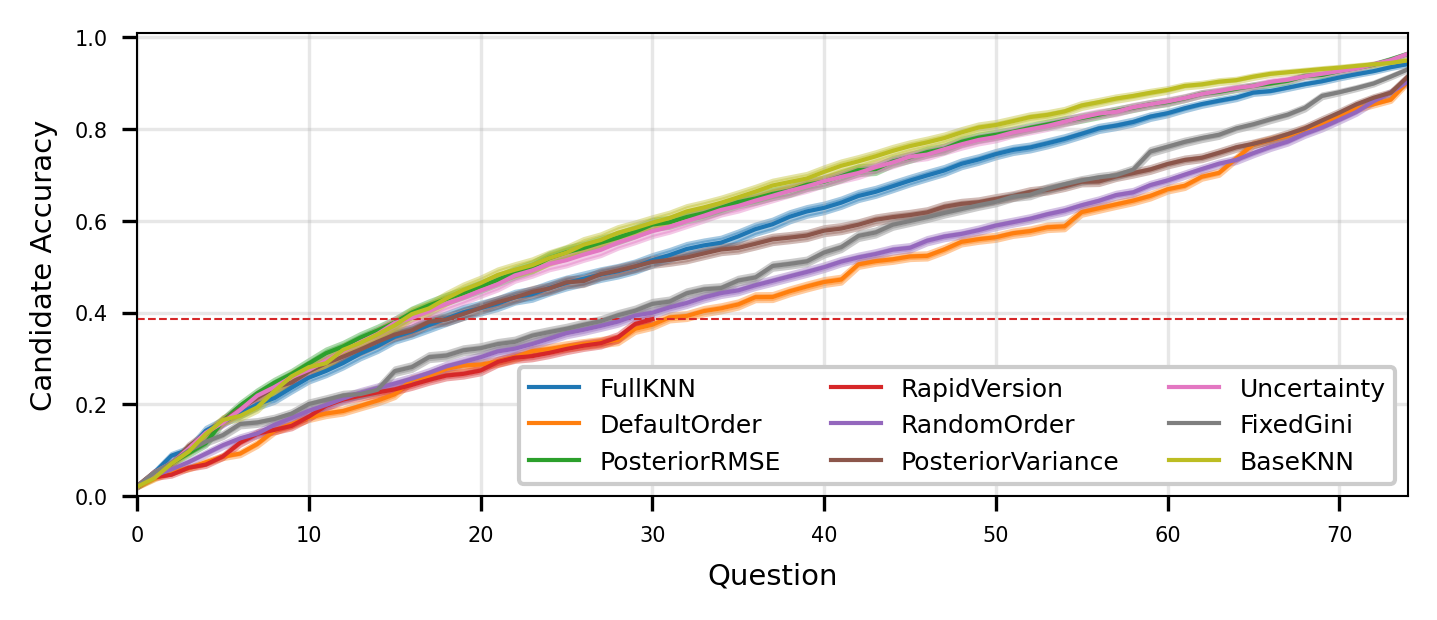

In [16]:
methods = ['FullKNN',
           'DefaultOrder',
           'PosteriorRMSE', 
           'RapidVersion',
           'RandomOrder', 
           'PosteriorVariance',
           'Uncertainty', 
           'FixedGini', 
           'BaseKNN'
        ]
fig, ax = showResults(results(methods),ncol=3,  singleUser=True, ylim=(0.0,1.01), metric='Base-kNN', ratio=0.45)
# fig, ax = showResults(results(methods), ylim=(0.0,1.01), legend=False, figax=(fig, ax), singleUser=True, linekwargs={'linestyle':'--'}, metric='Base-kNN')
ax.set(title='',
       ylabel='Candidate Accuracy')
ax.grid(alpha=0.3)
ax.set_xlabel('Question')
savefig(fig, "KNN_SingleUsers")

### Candidate Acuracy

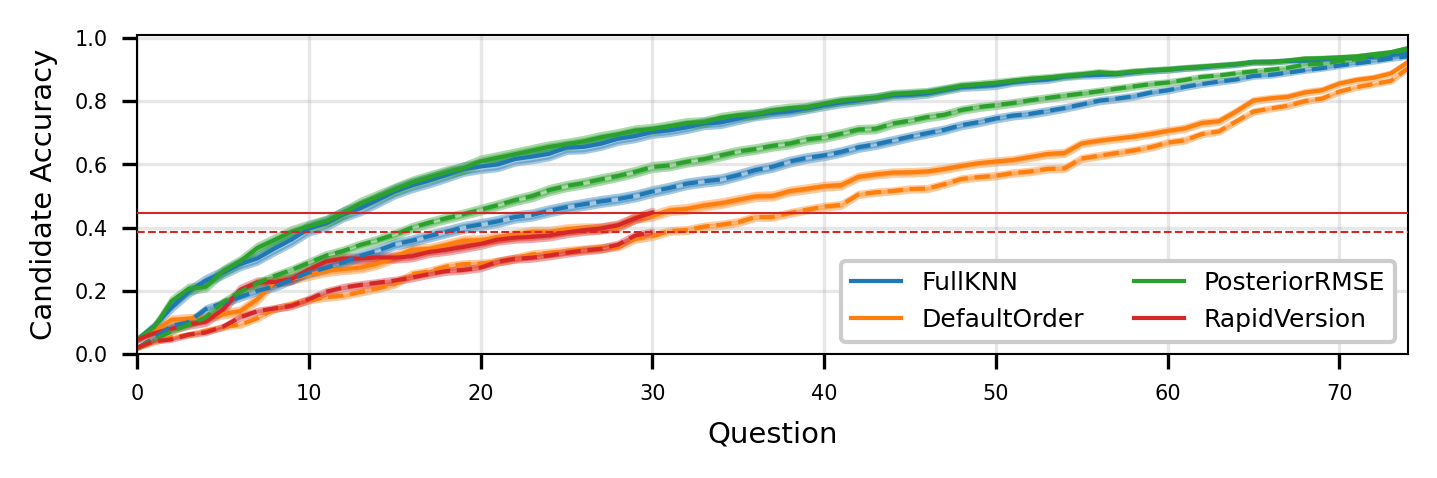

In [12]:
methods = [#'RandomOrder', 
           'FullKNN',
       #     'BaseKNN',
       #     'FixedGini', 
           'DefaultOrder',
       #     'Uncertainty', 
           'PosteriorRMSE', 
       #     'PosteriorVariance',
           'RapidVersion'
        ]
fig, ax = showResults(results(methods),ncol=2,  singleUser=True, ylim=(0.0,1.01), metric='Pred-kNN', ratio=0.35)
fig, ax = showResults(results(methods), ylim=(0.0,1.01), legend=False, figax=(fig, ax), singleUser=True, linekwargs={'linestyle':'--'}, metric='Base-kNN')
ax.set(title='',
       ylabel='Candidate Accuracy')
ax.grid(alpha=0.3)
ax.set_xlabel('Question')
savefig(fig, "KNN_ComparingBaseAndPred")

### Accuracy

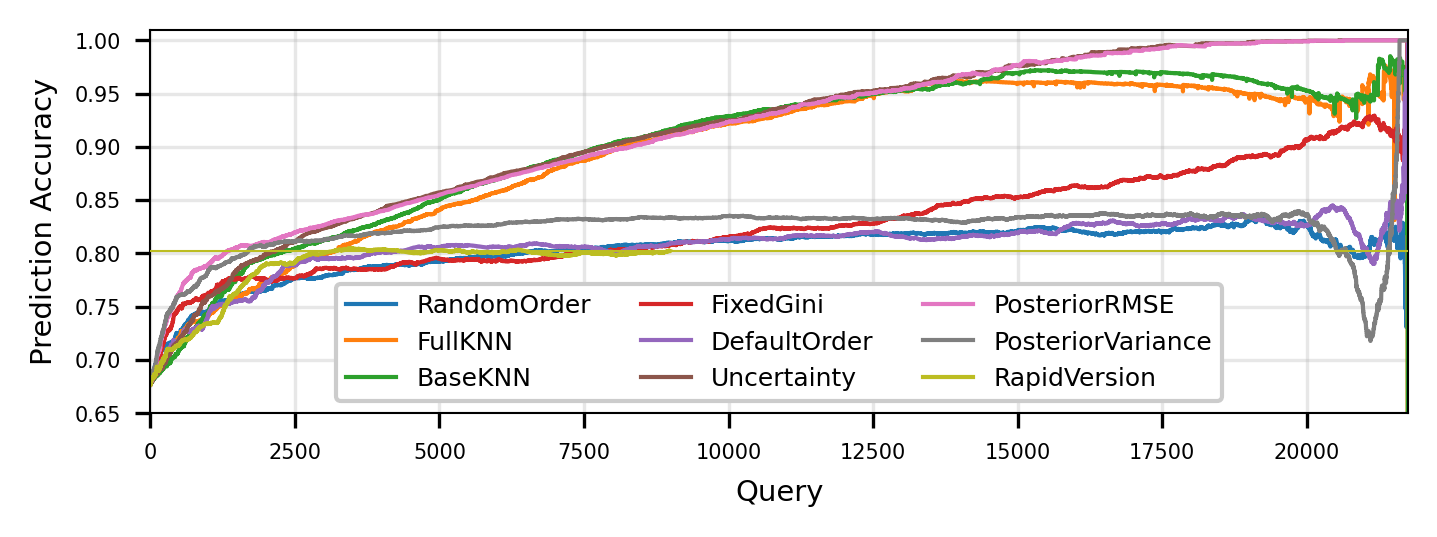

In [13]:
methods = ['RandomOrder', 
           'FullKNN',
           'BaseKNN',
           'FixedGini', 
           'DefaultOrder',
           'Uncertainty', 
           'PosteriorRMSE', 
           'PosteriorVariance',
           'RapidVersion'
        ]
fig, ax = showResults(results(methods), ylim=(0.65,1.01), title='', savefig=True, ratio=0.375)

### Adaptivity

In [23]:
pivots = {}
ranks = {}

methods = ['FullKNN',
           'DefaultOrder',
           'PosteriorRMSE', 
           'RapidVersion',
           'RandomOrder', 
           'PosteriorVariance',
           'Uncertainty', 
           'FixedGini', 
           'BaseKNN'
        ]

for method in methods:
    result = pd.read_csv(f'../../results/ALVAA/{folder_name}_{data_name}_IDEAL_{method}_{suffix}.csv', index_col=0)
    result['Counter'] = result.groupby('User').cumcount()
    pivots[method] = result.pivot(index='User', columns='Counter', values='Question')
    ranks[method] = pivots[method].apply(lambda row: row.sort_values().index, axis=1, result_type='expand')

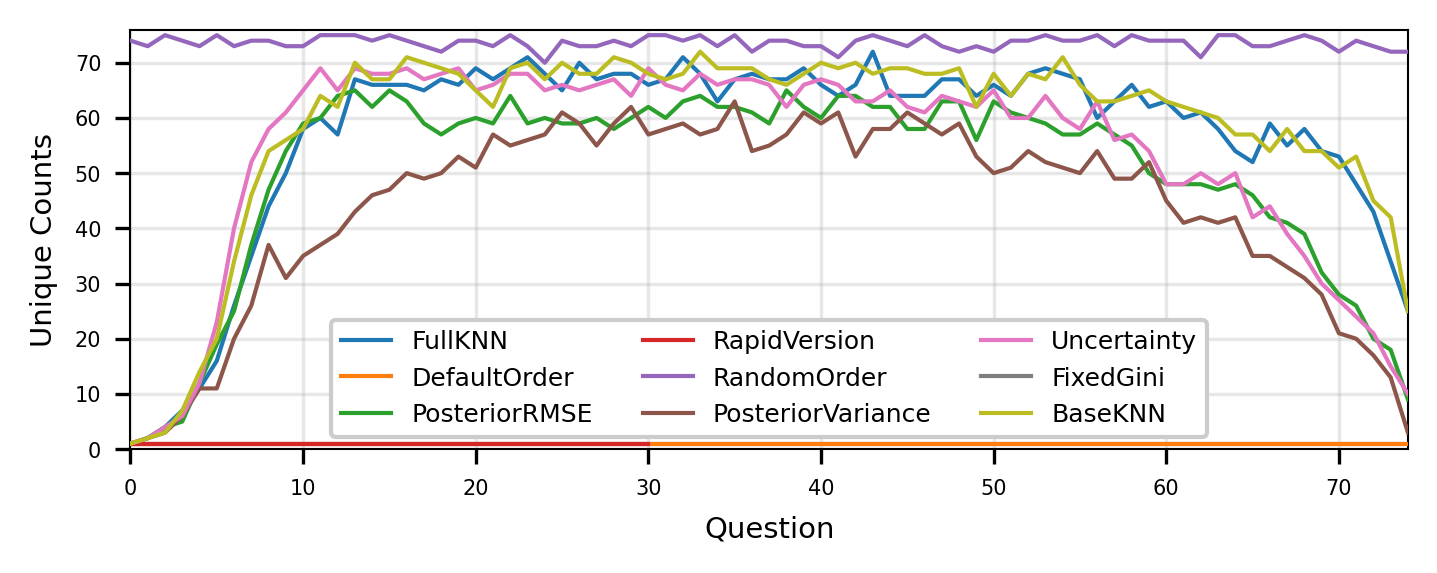

In [25]:
fig, ax = plt.subplots(figsize=(vis.textwidth,0.4*vis.textwidth))
for i, method in enumerate(pivots.keys()):
    zorder=4
    if method == 'FixedGini':
        zorder=0
    counts = pivots[method].nunique()
    ax.plot(counts.index, counts.values, color=f'C{i}', label=method, zorder=zorder, lw=1)
ax.set(ylim=(0,pivots['RandomOrder'].shape[1]+1),
       xlim=(0,pivots['RandomOrder'].shape[1]-1),
       xlabel='Question',
       ylabel='Unique Counts')
ax.grid(alpha=0.3)
ax.legend(ncol=3,facecolor='white', framealpha=1)
fig.tight_layout()
savefig(fig, "AdaptivityLine")

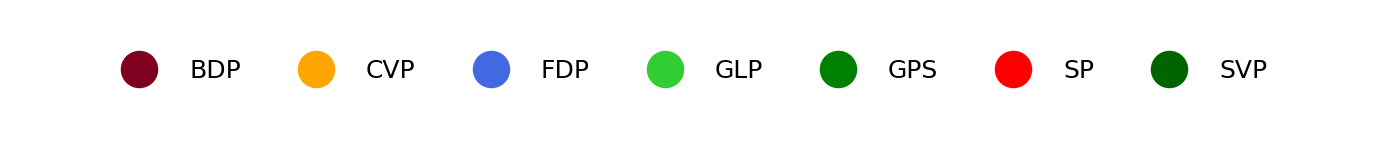

In [13]:
# Example dictionary mapping strings to colors
partycolors = {'SVP':'#006400','SP':'#FF0000','FDP':'#4169E1','CVP':'#FFA500',"GPS":'#008000','BDP':'#800020','GLP':'#32CD32'}
partycolors = dict(sorted(partycolors.items()))


# Creating a figure that contains a legend-like visual
fig, ax = plt.subplots(figsize=(vis.textwidth, 0.1*vis.textwidth))
ax.axis("off")  # Turn off the axis

# Create patches for the legend
patches = [plt.Line2D([0], [0], marker='o', color='w', label=string,
                      markerfacecolor=color, markersize=10) for string, color in partycolors.items()]

# Create a legend from these patches
legend = ax.legend(handles=patches, loc='center', frameon=False, handletextpad=1, ncols=7)

fig.tight_layout()

savefig(fig, 'Legend')


{'SVP': '#006400',
 'SP': '#FF0000',
 'FDP': '#4169E1',
 'CVP': '#FFA500',
 'Grüne': '#008000',
 'BDP': '#800020',
 'glp': '#32CD32'}